In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 64)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 64)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7228 - acc: 0.1000- ETA: 1s - lo
Epoch 00001: val_loss improved from inf to 2.65632, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/001-2.6563.hdf5
36805/36805 [==============================] - 32s 872us/sample - loss: 2.7227 - acc: 0.1000 - val_loss: 2.6563 - val_acc: 0.2092
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5915 - acc: 0.1751
Epoch 00002: val_loss improved from 2.65632 to 2.45005, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/002-2.4500.hdf5
36805/36805 [==============================] - 30s 811us/sample - loss: 2.5914 - acc: 0.1751 - val_loss: 2.4500 - val_acc: 0.2874
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4217 - acc: 0.2164
Epoch 00003: val_loss improved from 2.450

Epoch 22/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6793 - acc: 0.4612
Epoch 00022: val_loss improved from 1.51462 to 1.48733, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/022-1.4873.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 1.6792 - acc: 0.4611 - val_loss: 1.4873 - val_acc: 0.5628
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6577 - acc: 0.4679
Epoch 00023: val_loss improved from 1.48733 to 1.46926, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/023-1.4693.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 1.6573 - acc: 0.4681 - val_loss: 1.4693 - val_acc: 0.5693
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6486 - acc: 0.4692
Epoch 00024: val_loss improved from 1.46926 to 1.45467, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/024-1.454

Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4052 - acc: 0.5620
Epoch 00044: val_loss improved from 1.20054 to 1.19390, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/044-1.1939.hdf5
36805/36805 [==============================] - 30s 804us/sample - loss: 1.4052 - acc: 0.5619 - val_loss: 1.1939 - val_acc: 0.6501
Epoch 45/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3985 - acc: 0.5633
Epoch 00045: val_loss improved from 1.19390 to 1.17937, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/045-1.1794.hdf5
36805/36805 [==============================] - 29s 800us/sample - loss: 1.3986 - acc: 0.5632 - val_loss: 1.1794 - val_acc: 0.6557
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3912 - acc: 0.5659
Epoch 00046: val_loss improved from 1.17937 to 1.17202, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/046-1.172

Epoch 67/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2604 - acc: 0.6131
Epoch 00067: val_loss did not improve from 1.03378
36805/36805 [==============================] - 29s 801us/sample - loss: 1.2604 - acc: 0.6132 - val_loss: 1.0339 - val_acc: 0.7000
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2540 - acc: 0.6131
Epoch 00068: val_loss improved from 1.03378 to 1.02231, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/068-1.0223.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 1.2539 - acc: 0.6132 - val_loss: 1.0223 - val_acc: 0.7018
Epoch 69/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2503 - acc: 0.6141
Epoch 00069: val_loss improved from 1.02231 to 1.01597, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/069-1.0160.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 1.2502 - acc: 0.6142 -

36800/36805 [============================>.] - ETA: 0s - loss: 1.1670 - acc: 0.6448
Epoch 00090: val_loss did not improve from 0.94416
36805/36805 [==============================] - 30s 802us/sample - loss: 1.1671 - acc: 0.6447 - val_loss: 0.9499 - val_acc: 0.7265
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1735 - acc: 0.6409
Epoch 00091: val_loss improved from 0.94416 to 0.93844, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/091-0.9384.hdf5
36805/36805 [==============================] - 30s 805us/sample - loss: 1.1737 - acc: 0.6409 - val_loss: 0.9384 - val_acc: 0.7293
Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1668 - acc: 0.6421
Epoch 00092: val_loss improved from 0.93844 to 0.93396, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/092-0.9340.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 1.1667 - acc: 0.6421 - val_loss: 0.

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1024 - acc: 0.6662
Epoch 00116: val_loss improved from 0.88286 to 0.87431, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/116-0.8743.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 1.1024 - acc: 0.6662 - val_loss: 0.8743 - val_acc: 0.7533
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1129 - acc: 0.6602
Epoch 00117: val_loss did not improve from 0.87431
36805/36805 [==============================] - 29s 801us/sample - loss: 1.1125 - acc: 0.6603 - val_loss: 0.8757 - val_acc: 0.7519
Epoch 118/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1084 - acc: 0.6633
Epoch 00118: val_loss improved from 0.87431 to 0.87092, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/118-0.8709.hdf5
36805/36805 [==============================] - 29s 796us/sample - loss: 1.1087 - acc: 0.663

36800/36805 [============================>.] - ETA: 0s - loss: 1.0674 - acc: 0.6792
Epoch 00142: val_loss improved from 0.83533 to 0.83507, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/142-0.8351.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 1.0675 - acc: 0.6792 - val_loss: 0.8351 - val_acc: 0.7652
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0700 - acc: 0.6789
Epoch 00143: val_loss did not improve from 0.83507
36805/36805 [==============================] - 29s 796us/sample - loss: 1.0700 - acc: 0.6789 - val_loss: 0.8360 - val_acc: 0.7713
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0684 - acc: 0.6793
Epoch 00144: val_loss improved from 0.83507 to 0.83061, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/144-0.8306.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 1.0684 - acc: 0.6792 - val_loss: 

Epoch 168/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0301 - acc: 0.6887
Epoch 00168: val_loss did not improve from 0.79847
36805/36805 [==============================] - 29s 798us/sample - loss: 1.0295 - acc: 0.6888 - val_loss: 0.8001 - val_acc: 0.7799
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0304 - acc: 0.6886
Epoch 00169: val_loss improved from 0.79847 to 0.79722, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/169-0.7972.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 1.0305 - acc: 0.6885 - val_loss: 0.7972 - val_acc: 0.7799
Epoch 170/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0305 - acc: 0.6897
Epoch 00170: val_loss did not improve from 0.79722
36805/36805 [==============================] - 29s 800us/sample - loss: 1.0306 - acc: 0.6896 - val_loss: 0.7977 - val_acc: 0.7792
Epoch 171/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 1.0071 - acc: 0.6983
Epoch 00194: val_loss did not improve from 0.76721
36805/36805 [==============================] - 29s 798us/sample - loss: 1.0072 - acc: 0.6983 - val_loss: 0.7738 - val_acc: 0.7892
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0020 - acc: 0.7006
Epoch 00195: val_loss did not improve from 0.76721
36805/36805 [==============================] - 29s 796us/sample - loss: 1.0020 - acc: 0.7006 - val_loss: 0.7681 - val_acc: 0.7883
Epoch 196/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0116 - acc: 0.6981
Epoch 00196: val_loss did not improve from 0.76721
36805/36805 [==============================] - 29s 791us/sample - loss: 1.0118 - acc: 0.6981 - val_loss: 0.7758 - val_acc: 0.7855
Epoch 197/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0111 - acc: 0.6991
Epoch 00197: val_loss did not improve from 0.76721
36805/36805 [===============

Epoch 221/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9803 - acc: 0.7065
Epoch 00221: val_loss did not improve from 0.75124
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9800 - acc: 0.7066 - val_loss: 0.7536 - val_acc: 0.7890
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9879 - acc: 0.7005
Epoch 00222: val_loss did not improve from 0.75124
36805/36805 [==============================] - 29s 794us/sample - loss: 0.9879 - acc: 0.7005 - val_loss: 0.7524 - val_acc: 0.7945
Epoch 223/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9791 - acc: 0.7019
Epoch 00223: val_loss did not improve from 0.75124
36805/36805 [==============================] - 29s 794us/sample - loss: 0.9790 - acc: 0.7021 - val_loss: 0.7567 - val_acc: 0.7939
Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9807 - acc: 0.7067
Epoch 00224: val_loss improved from 0.75124 to 0.74710, saving mo

Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9700 - acc: 0.7112
Epoch 00248: val_loss did not improve from 0.73308
36805/36805 [==============================] - 29s 799us/sample - loss: 0.9699 - acc: 0.7112 - val_loss: 0.7354 - val_acc: 0.8018
Epoch 249/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9642 - acc: 0.7121
Epoch 00249: val_loss improved from 0.73308 to 0.72669, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/249-0.7267.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 0.9643 - acc: 0.7122 - val_loss: 0.7267 - val_acc: 0.8004
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9623 - acc: 0.7126
Epoch 00250: val_loss did not improve from 0.72669
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9623 - acc: 0.7125 - val_loss: 0.7363 - val_acc: 0.8022
Epoch 251/500
36736/36805 [============================>.] - E

Epoch 275/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9497 - acc: 0.7145
Epoch 00275: val_loss did not improve from 0.71784
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9498 - acc: 0.7145 - val_loss: 0.7261 - val_acc: 0.8039
Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9541 - acc: 0.7166
Epoch 00276: val_loss did not improve from 0.71784
36805/36805 [==============================] - 29s 795us/sample - loss: 0.9541 - acc: 0.7166 - val_loss: 0.7232 - val_acc: 0.8034
Epoch 277/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9493 - acc: 0.7149
Epoch 00277: val_loss did not improve from 0.71784
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9493 - acc: 0.7148 - val_loss: 0.7245 - val_acc: 0.8041
Epoch 278/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9459 - acc: 0.7168
Epoch 00278: val_loss did not improve from 0.71784
36805/36805 [=

Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9391 - acc: 0.7193
Epoch 00303: val_loss improved from 0.70570 to 0.70554, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/303-0.7055.hdf5
36805/36805 [==============================] - 29s 798us/sample - loss: 0.9390 - acc: 0.7193 - val_loss: 0.7055 - val_acc: 0.8071
Epoch 304/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9389 - acc: 0.7228
Epoch 00304: val_loss did not improve from 0.70554
36805/36805 [==============================] - 29s 795us/sample - loss: 0.9388 - acc: 0.7228 - val_loss: 0.7073 - val_acc: 0.8090
Epoch 305/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9388 - acc: 0.7218
Epoch 00305: val_loss did not improve from 0.70554
36805/36805 [==============================] - 29s 794us/sample - loss: 0.9389 - acc: 0.7218 - val_loss: 0.7074 - val_acc: 0.8055
Epoch 306/500
36800/36805 [============================>.] - E

36736/36805 [============================>.] - ETA: 0s - loss: 0.9411 - acc: 0.7188
Epoch 00330: val_loss did not improve from 0.69118
36805/36805 [==============================] - 29s 800us/sample - loss: 0.9409 - acc: 0.7188 - val_loss: 0.6987 - val_acc: 0.8109
Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9240 - acc: 0.7252
Epoch 00331: val_loss did not improve from 0.69118
36805/36805 [==============================] - 29s 797us/sample - loss: 0.9240 - acc: 0.7252 - val_loss: 0.7034 - val_acc: 0.8097
Epoch 332/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9205 - acc: 0.7248
Epoch 00332: val_loss did not improve from 0.69118
36805/36805 [==============================] - 29s 796us/sample - loss: 0.9204 - acc: 0.7248 - val_loss: 0.6950 - val_acc: 0.8141
Epoch 333/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9225 - acc: 0.7250
Epoch 00333: val_loss did not improve from 0.69118
36805/36805 [===============

Epoch 358/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9094 - acc: 0.7295
Epoch 00358: val_loss did not improve from 0.68100
36805/36805 [==============================] - 29s 788us/sample - loss: 0.9095 - acc: 0.7295 - val_loss: 0.6906 - val_acc: 0.8153
Epoch 359/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9191 - acc: 0.7253
Epoch 00359: val_loss did not improve from 0.68100
36805/36805 [==============================] - 29s 786us/sample - loss: 0.9190 - acc: 0.7252 - val_loss: 0.6898 - val_acc: 0.8125
Epoch 360/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9249 - acc: 0.7252
Epoch 00360: val_loss did not improve from 0.68100
36805/36805 [==============================] - 29s 786us/sample - loss: 0.9248 - acc: 0.7252 - val_loss: 0.6870 - val_acc: 0.8155
Epoch 361/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9171 - acc: 0.7251
Epoch 00361: val_loss did not improve from 0.68100
36805/36805 [=

Epoch 387/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9098 - acc: 0.7292
Epoch 00387: val_loss did not improve from 0.67138
36805/36805 [==============================] - 29s 779us/sample - loss: 0.9099 - acc: 0.7292 - val_loss: 0.6782 - val_acc: 0.8160
Epoch 388/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8997 - acc: 0.7305
Epoch 00388: val_loss did not improve from 0.67138
36805/36805 [==============================] - 29s 780us/sample - loss: 0.8996 - acc: 0.7305 - val_loss: 0.6780 - val_acc: 0.8213
Epoch 389/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9083 - acc: 0.7280
Epoch 00389: val_loss did not improve from 0.67138
36805/36805 [==============================] - 29s 783us/sample - loss: 0.9084 - acc: 0.7278 - val_loss: 0.6794 - val_acc: 0.8148
Epoch 390/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9069 - acc: 0.7295
Epoch 00390: val_loss did not improve from 0.67138
36805/36805 [=

Epoch 415/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8970 - acc: 0.7313
Epoch 00415: val_loss did not improve from 0.66655
36805/36805 [==============================] - 29s 792us/sample - loss: 0.8965 - acc: 0.7314 - val_loss: 0.6724 - val_acc: 0.8206
Epoch 416/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8985 - acc: 0.7335
Epoch 00416: val_loss did not improve from 0.66655
36805/36805 [==============================] - 29s 790us/sample - loss: 0.8982 - acc: 0.7336 - val_loss: 0.6689 - val_acc: 0.8225
Epoch 417/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8937 - acc: 0.7354
Epoch 00417: val_loss did not improve from 0.66655
36805/36805 [==============================] - 29s 791us/sample - loss: 0.8936 - acc: 0.7354 - val_loss: 0.6668 - val_acc: 0.8220
Epoch 418/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8942 - acc: 0.7340
Epoch 00418: val_loss did not improve from 0.66655
36805/36805 [=

Epoch 442/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8857 - acc: 0.7350
Epoch 00442: val_loss did not improve from 0.66000
36805/36805 [==============================] - 29s 786us/sample - loss: 0.8857 - acc: 0.7350 - val_loss: 0.6602 - val_acc: 0.8223
Epoch 443/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8851 - acc: 0.7364
Epoch 00443: val_loss did not improve from 0.66000
36805/36805 [==============================] - 29s 779us/sample - loss: 0.8851 - acc: 0.7364 - val_loss: 0.6685 - val_acc: 0.8241
Epoch 444/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8950 - acc: 0.7354
Epoch 00444: val_loss improved from 0.66000 to 0.65975, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_3_conv_checkpoint/444-0.6598.hdf5
36805/36805 [==============================] - 29s 784us/sample - loss: 0.8950 - acc: 0.7353 - val_loss: 0.6598 - val_acc: 0.8251
Epoch 445/500
36736/36805 [============================>.] - E

Epoch 470/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8793 - acc: 0.7385
Epoch 00470: val_loss did not improve from 0.65326
36805/36805 [==============================] - 29s 791us/sample - loss: 0.8792 - acc: 0.7385 - val_loss: 0.6548 - val_acc: 0.8260
Epoch 471/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8842 - acc: 0.7366
Epoch 00471: val_loss did not improve from 0.65326
36805/36805 [==============================] - 29s 790us/sample - loss: 0.8841 - acc: 0.7366 - val_loss: 0.6649 - val_acc: 0.8244
Epoch 472/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8781 - acc: 0.7362
Epoch 00472: val_loss did not improve from 0.65326
36805/36805 [==============================] - 29s 792us/sample - loss: 0.8780 - acc: 0.7363 - val_loss: 0.6554 - val_acc: 0.8276
Epoch 473/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8819 - acc: 0.7345
Epoch 00473: val_loss did not improve from 0.65326
36805/36805 [=

Epoch 498/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8733 - acc: 0.7407
Epoch 00498: val_loss did not improve from 0.64534
36805/36805 [==============================] - 29s 780us/sample - loss: 0.8732 - acc: 0.7407 - val_loss: 0.6513 - val_acc: 0.8265
Epoch 499/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8724 - acc: 0.7396
Epoch 00499: val_loss did not improve from 0.64534
36805/36805 [==============================] - 29s 789us/sample - loss: 0.8723 - acc: 0.7396 - val_loss: 0.6509 - val_acc: 0.8258
Epoch 500/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8760 - acc: 0.7385
Epoch 00500: val_loss did not improve from 0.64534
36805/36805 [==============================] - 29s 793us/sample - loss: 0.8760 - acc: 0.7385 - val_loss: 0.6479 - val_acc: 0.8255

1D_CNN_custom_multi_2_GAP_DO_3_conv Model


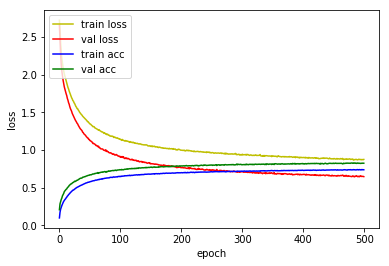

4815/4815 [==============================] - 2s 383us/sample - loss: 0.7135 - acc: 0.7940
Loss: 0.7134613753355429 Accuracy: 0.79397714

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6871 - acc: 0.1213
Epoch 00001: val_loss improved from inf to 2.53735, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/001-2.5373.hdf5
36805/36805 [==============================] - 31s 853us/sample - loss: 2.6871 - acc: 0.1213 - val_loss: 2.5373 - val_acc: 0.2427
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3904 - acc: 0.2281
Epoch 00002: val_loss improved from 2.53735 to 2.14867, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/002-2.1487.hdf5
36805/36805 [==============================] - 30s 818us/sample - loss: 2.3900 - acc: 0.2280 - val_loss: 2.1487 - val_acc: 0.3282
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 1.3582 - acc: 0.5676
Epoch 00022: val_loss improved from 1.18066 to 1.16188, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/022-1.1619.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 1.3582 - acc: 0.5676 - val_loss: 1.1619 - val_acc: 0.6506
Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3429 - acc: 0.5710
Epoch 00023: val_loss did not improve from 1.16188
36805/36805 [==============================] - 30s 818us/sample - loss: 1.3436 - acc: 0.5708 - val_loss: 1.1643 - val_acc: 0.6564
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3313 - acc: 0.5764
Epoch 00024: val_loss improved from 1.16188 to 1.11913, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/024-1.1191.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 1.3308 - acc: 0.5766 - val_loss: 1.

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0970 - acc: 0.6549
Epoch 00045: val_loss improved from 0.90321 to 0.89380, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/045-0.8938.hdf5
36805/36805 [==============================] - 30s 818us/sample - loss: 1.0969 - acc: 0.6550 - val_loss: 0.8938 - val_acc: 0.7407
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0833 - acc: 0.6623
Epoch 00046: val_loss did not improve from 0.89380
36805/36805 [==============================] - 30s 817us/sample - loss: 1.0833 - acc: 0.6623 - val_loss: 0.8939 - val_acc: 0.7275
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0874 - acc: 0.6626
Epoch 00047: val_loss did not improve from 0.89380
36805/36805 [==============================] - 30s 819us/sample - loss: 1.0873 - acc: 0.6626 - val_loss: 0.8949 - val_acc: 0.7382
Epoch 48/500
36736/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.9639 - acc: 0.7068
Epoch 00068: val_loss did not improve from 0.77671
36805/36805 [==============================] - 30s 816us/sample - loss: 0.9640 - acc: 0.7068 - val_loss: 0.7837 - val_acc: 0.7736
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9549 - acc: 0.7062
Epoch 00069: val_loss improved from 0.77671 to 0.76605, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/069-0.7660.hdf5
36805/36805 [==============================] - 30s 818us/sample - loss: 0.9549 - acc: 0.7062 - val_loss: 0.7660 - val_acc: 0.7768
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9529 - acc: 0.7087
Epoch 00070: val_loss did not improve from 0.76605
36805/36805 [==============================] - 30s 819us/sample - loss: 0.9529 - acc: 0.7086 - val_loss: 0.7736 - val_acc: 0.7775
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 92/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8775 - acc: 0.7338
Epoch 00092: val_loss improved from 0.70264 to 0.70038, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/092-0.7004.hdf5
36805/36805 [==============================] - 30s 814us/sample - loss: 0.8775 - acc: 0.7338 - val_loss: 0.7004 - val_acc: 0.8041
Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8756 - acc: 0.7342
Epoch 00093: val_loss improved from 0.70038 to 0.69931, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/093-0.6993.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 0.8759 - acc: 0.7342 - val_loss: 0.6993 - val_acc: 0.8057
Epoch 94/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8786 - acc: 0.7342
Epoch 00094: val_loss improved from 0.69931 to 0.69307, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/094-0.693

Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8231 - acc: 0.7541
Epoch 00118: val_loss improved from 0.64850 to 0.64014, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/118-0.6401.hdf5
36805/36805 [==============================] - 29s 801us/sample - loss: 0.8232 - acc: 0.7541 - val_loss: 0.6401 - val_acc: 0.8232
Epoch 119/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8276 - acc: 0.7546
Epoch 00119: val_loss did not improve from 0.64014
36805/36805 [==============================] - 30s 816us/sample - loss: 0.8279 - acc: 0.7544 - val_loss: 0.6551 - val_acc: 0.8188
Epoch 120/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8183 - acc: 0.7556
Epoch 00120: val_loss improved from 0.64014 to 0.63993, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/120-0.6399.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 0.8183 - acc: 0.755

36800/36805 [============================>.] - ETA: 0s - loss: 0.7782 - acc: 0.7679
Epoch 00143: val_loss improved from 0.60824 to 0.60062, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/143-0.6006.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 0.7781 - acc: 0.7679 - val_loss: 0.6006 - val_acc: 0.8358
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7809 - acc: 0.7684
Epoch 00144: val_loss did not improve from 0.60062
36805/36805 [==============================] - 30s 814us/sample - loss: 0.7809 - acc: 0.7684 - val_loss: 0.6152 - val_acc: 0.8311
Epoch 145/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7790 - acc: 0.7686
Epoch 00145: val_loss did not improve from 0.60062
36805/36805 [==============================] - 30s 813us/sample - loss: 0.7789 - acc: 0.7685 - val_loss: 0.6156 - val_acc: 0.8351
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss:

36736/36805 [============================>.] - ETA: 0s - loss: 0.7462 - acc: 0.7796
Epoch 00168: val_loss did not improve from 0.57276
36805/36805 [==============================] - 30s 817us/sample - loss: 0.7462 - acc: 0.7797 - val_loss: 0.5765 - val_acc: 0.8474
Epoch 169/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7478 - acc: 0.7800
Epoch 00169: val_loss did not improve from 0.57276
36805/36805 [==============================] - 30s 805us/sample - loss: 0.7487 - acc: 0.7798 - val_loss: 0.5738 - val_acc: 0.8453
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7391 - acc: 0.7802
Epoch 00170: val_loss did not improve from 0.57276
36805/36805 [==============================] - 29s 801us/sample - loss: 0.7391 - acc: 0.7802 - val_loss: 0.5759 - val_acc: 0.8458
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7439 - acc: 0.7784
Epoch 00171: val_loss did not improve from 0.57276
36805/36805 [===============

Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7130 - acc: 0.7909
Epoch 00195: val_loss did not improve from 0.53901
36805/36805 [==============================] - 30s 816us/sample - loss: 0.7130 - acc: 0.7909 - val_loss: 0.5470 - val_acc: 0.8553
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7116 - acc: 0.7884
Epoch 00196: val_loss did not improve from 0.53901
36805/36805 [==============================] - 30s 816us/sample - loss: 0.7115 - acc: 0.7884 - val_loss: 0.5469 - val_acc: 0.8523
Epoch 197/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7063 - acc: 0.7916
Epoch 00197: val_loss did not improve from 0.53901
36805/36805 [==============================] - 30s 816us/sample - loss: 0.7057 - acc: 0.7919 - val_loss: 0.5466 - val_acc: 0.8565
Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7060 - acc: 0.7898
Epoch 00198: val_loss improved from 0.53901 to 0.53204, saving mo

Epoch 222/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6759 - acc: 0.8005
Epoch 00222: val_loss improved from 0.51312 to 0.51015, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/222-0.5102.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 0.6760 - acc: 0.8005 - val_loss: 0.5102 - val_acc: 0.8644
Epoch 223/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6720 - acc: 0.8025
Epoch 00223: val_loss improved from 0.51015 to 0.50841, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/223-0.5084.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 0.6720 - acc: 0.8025 - val_loss: 0.5084 - val_acc: 0.8661
Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6737 - acc: 0.8040
Epoch 00224: val_loss did not improve from 0.50841
36805/36805 [==============================] - 30s 816us/sample - loss: 0.6738 - acc: 0.803

Epoch 249/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6470 - acc: 0.8086
Epoch 00249: val_loss did not improve from 0.48553
36805/36805 [==============================] - 29s 800us/sample - loss: 0.6473 - acc: 0.8084 - val_loss: 0.4881 - val_acc: 0.8682
Epoch 250/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6531 - acc: 0.8080
Epoch 00250: val_loss did not improve from 0.48553
36805/36805 [==============================] - 30s 803us/sample - loss: 0.6536 - acc: 0.8079 - val_loss: 0.4858 - val_acc: 0.8689
Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6506 - acc: 0.8088- ETA: 2
Epoch 00251: val_loss did not improve from 0.48553
36805/36805 [==============================] - 29s 798us/sample - loss: 0.6505 - acc: 0.8088 - val_loss: 0.4880 - val_acc: 0.8686
Epoch 252/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6462 - acc: 0.8081
Epoch 00252: val_loss did not improve from 0.48553
36805/

Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6298 - acc: 0.8145
Epoch 00276: val_loss improved from 0.47131 to 0.46957, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/276-0.4696.hdf5
36805/36805 [==============================] - 30s 812us/sample - loss: 0.6298 - acc: 0.8145 - val_loss: 0.4696 - val_acc: 0.8782
Epoch 277/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6230 - acc: 0.8169
Epoch 00277: val_loss improved from 0.46957 to 0.46508, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/277-0.4651.hdf5
36805/36805 [==============================] - 30s 809us/sample - loss: 0.6229 - acc: 0.8169 - val_loss: 0.4651 - val_acc: 0.8772
Epoch 278/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6243 - acc: 0.8171
Epoch 00278: val_loss did not improve from 0.46508
36805/36805 [==============================] - 30s 811us/sample - loss: 0.6243 - acc: 0.817

36800/36805 [============================>.] - ETA: 0s - loss: 0.6038 - acc: 0.8226
Epoch 00302: val_loss did not improve from 0.45367
36805/36805 [==============================] - 30s 809us/sample - loss: 0.6037 - acc: 0.8226 - val_loss: 0.4596 - val_acc: 0.8810
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6044 - acc: 0.8211
Epoch 00303: val_loss improved from 0.45367 to 0.45196, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/303-0.4520.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.6043 - acc: 0.8211 - val_loss: 0.4520 - val_acc: 0.8789
Epoch 304/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6015 - acc: 0.8217
Epoch 00304: val_loss did not improve from 0.45196
36805/36805 [==============================] - 30s 808us/sample - loss: 0.6015 - acc: 0.8217 - val_loss: 0.4596 - val_acc: 0.8770
Epoch 305/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 330/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5878 - acc: 0.8257
Epoch 00330: val_loss improved from 0.44063 to 0.43642, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/330-0.4364.hdf5
36805/36805 [==============================] - 30s 809us/sample - loss: 0.5878 - acc: 0.8257 - val_loss: 0.4364 - val_acc: 0.8840
Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5791 - acc: 0.8273
Epoch 00331: val_loss did not improve from 0.43642
36805/36805 [==============================] - 30s 809us/sample - loss: 0.5791 - acc: 0.8273 - val_loss: 0.4401 - val_acc: 0.8852
Epoch 332/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5810 - acc: 0.8271
Epoch 00332: val_loss did not improve from 0.43642
36805/36805 [==============================] - 30s 806us/sample - loss: 0.5810 - acc: 0.8271 - val_loss: 0.4415 - val_acc: 0.8840
Epoch 333/500
36800/36805 [============================>.] - E

Epoch 358/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5714 - acc: 0.8297
Epoch 00358: val_loss did not improve from 0.43121
36805/36805 [==============================] - 29s 800us/sample - loss: 0.5714 - acc: 0.8296 - val_loss: 0.4358 - val_acc: 0.8845
Epoch 359/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5692 - acc: 0.8314
Epoch 00359: val_loss did not improve from 0.43121
36805/36805 [==============================] - 29s 801us/sample - loss: 0.5692 - acc: 0.8314 - val_loss: 0.4340 - val_acc: 0.8854
Epoch 360/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5694 - acc: 0.8327
Epoch 00360: val_loss did not improve from 0.43121
36805/36805 [==============================] - 29s 789us/sample - loss: 0.5691 - acc: 0.8328 - val_loss: 0.4334 - val_acc: 0.8868
Epoch 361/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5626 - acc: 0.8325
Epoch 00361: val_loss did not improve from 0.43121
36805/36805 [=

Epoch 386/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5572 - acc: 0.8340
Epoch 00386: val_loss did not improve from 0.42604
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5571 - acc: 0.8340 - val_loss: 0.4381 - val_acc: 0.8838
Epoch 387/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5523 - acc: 0.8364
Epoch 00387: val_loss improved from 0.42604 to 0.42603, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/387-0.4260.hdf5
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5523 - acc: 0.8363 - val_loss: 0.4260 - val_acc: 0.8901
Epoch 388/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5569 - acc: 0.8342
Epoch 00388: val_loss did not improve from 0.42603
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5568 - acc: 0.8342 - val_loss: 0.4328 - val_acc: 0.8859
Epoch 389/500
36800/36805 [============================>.] - E

36736/36805 [============================>.] - ETA: 0s - loss: 0.5439 - acc: 0.8386
Epoch 00413: val_loss did not improve from 0.41808
36805/36805 [==============================] - 29s 798us/sample - loss: 0.5439 - acc: 0.8387 - val_loss: 0.4251 - val_acc: 0.8842
Epoch 414/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5467 - acc: 0.8354
Epoch 00414: val_loss did not improve from 0.41808
36805/36805 [==============================] - 29s 797us/sample - loss: 0.5464 - acc: 0.8355 - val_loss: 0.4295 - val_acc: 0.8868
Epoch 415/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5406 - acc: 0.8393
Epoch 00415: val_loss improved from 0.41808 to 0.41486, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_4_conv_checkpoint/415-0.4149.hdf5
36805/36805 [==============================] - 29s 792us/sample - loss: 0.5407 - acc: 0.8392 - val_loss: 0.4149 - val_acc: 0.8912
Epoch 416/500
36800/36805 [============================>.] - ETA: 0s - loss:

36736/36805 [============================>.] - ETA: 0s - loss: 0.5250 - acc: 0.8437
Epoch 00440: val_loss did not improve from 0.40974
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5250 - acc: 0.8436 - val_loss: 0.4173 - val_acc: 0.8880
Epoch 441/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5269 - acc: 0.8439
Epoch 00441: val_loss did not improve from 0.40974
36805/36805 [==============================] - 29s 800us/sample - loss: 0.5268 - acc: 0.8439 - val_loss: 0.4104 - val_acc: 0.8917
Epoch 442/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5230 - acc: 0.8435
Epoch 00442: val_loss did not improve from 0.40974
36805/36805 [==============================] - 29s 798us/sample - loss: 0.5229 - acc: 0.8435 - val_loss: 0.4177 - val_acc: 0.8889
Epoch 443/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5277 - acc: 0.8418
Epoch 00443: val_loss did not improve from 0.40974
36805/36805 [===============

Epoch 469/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5137 - acc: 0.8472
Epoch 00469: val_loss did not improve from 0.40678
36805/36805 [==============================] - 29s 800us/sample - loss: 0.5137 - acc: 0.8472 - val_loss: 0.4085 - val_acc: 0.8903
Epoch 470/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5141 - acc: 0.8445
Epoch 00470: val_loss did not improve from 0.40678
36805/36805 [==============================] - 29s 799us/sample - loss: 0.5140 - acc: 0.8445 - val_loss: 0.4077 - val_acc: 0.8959
Epoch 471/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5109 - acc: 0.8443
Epoch 00471: val_loss did not improve from 0.40678
36805/36805 [==============================] - 29s 801us/sample - loss: 0.5109 - acc: 0.8443 - val_loss: 0.4114 - val_acc: 0.8924
Epoch 472/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5153 - acc: 0.8457
Epoch 00472: val_loss did not improve from 0.40678
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.5038 - acc: 0.8485
Epoch 00497: val_loss did not improve from 0.40251
36805/36805 [==============================] - 29s 794us/sample - loss: 0.5037 - acc: 0.8485 - val_loss: 0.4049 - val_acc: 0.8952
Epoch 498/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5048 - acc: 0.8487
Epoch 00498: val_loss did not improve from 0.40251
36805/36805 [==============================] - 29s 789us/sample - loss: 0.5047 - acc: 0.8487 - val_loss: 0.4155 - val_acc: 0.8915
Epoch 499/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5026 - acc: 0.8489
Epoch 00499: val_loss did not improve from 0.40251
36805/36805 [==============================] - 29s 793us/sample - loss: 0.5025 - acc: 0.8489 - val_loss: 0.4051 - val_acc: 0.8905
Epoch 500/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5062 - acc: 0.8477
Epoch 00500: val_loss improved from 0.40251 to 0.39998, saving model to model/c

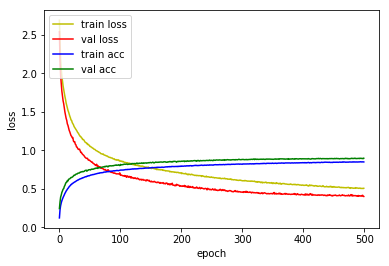

4815/4815 [==============================] - 2s 382us/sample - loss: 0.4633 - acc: 0.8665
Loss: 0.4633347888849482 Accuracy: 0.866459

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5803 - acc: 0.1586
Epoch 00001: val_loss improved from inf to 2.16382, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/001-2.1638.hdf5
36805/36805 [==============================] - 32s 868us/sample - loss: 2.5800 - acc: 0.1587 - val_loss: 2.1638 - val_acc: 0.3501
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1127 - acc: 0.3047- ETA: 0s - loss: 2.1156 - acc:
Epoch 00002: val_loss improved from 2.16382 to 1.86051, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/002-1.8605.hdf5
36805/36805 [==============================] - 30s 813us/sample - loss: 2.1126 - acc: 0.3048 - val_loss: 1.8605 - val_acc: 0.4095
Epoch 3/500
36800/36805 [========

36736/36805 [============================>.] - ETA: 0s - loss: 0.9208 - acc: 0.7263
Epoch 00022: val_loss did not improve from 0.74595
36805/36805 [==============================] - 30s 811us/sample - loss: 0.9206 - acc: 0.7264 - val_loss: 0.7483 - val_acc: 0.7885
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8999 - acc: 0.7316
Epoch 00023: val_loss improved from 0.74595 to 0.70315, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/023-0.7031.hdf5
36805/36805 [==============================] - 30s 814us/sample - loss: 0.8998 - acc: 0.7316 - val_loss: 0.7031 - val_acc: 0.7957
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8750 - acc: 0.7389
Epoch 00024: val_loss improved from 0.70315 to 0.69434, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/024-0.6943.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.8750 - acc: 0.7389 - val_loss: 0.

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6230 - acc: 0.8195
Epoch 00045: val_loss did not improve from 0.45957
36805/36805 [==============================] - 30s 815us/sample - loss: 0.6230 - acc: 0.8195 - val_loss: 0.4807 - val_acc: 0.8642
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6144 - acc: 0.8244
Epoch 00046: val_loss improved from 0.45957 to 0.45746, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/046-0.4575.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 0.6143 - acc: 0.8244 - val_loss: 0.4575 - val_acc: 0.8724
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6162 - acc: 0.8206
Epoch 00047: val_loss did not improve from 0.45746
36805/36805 [==============================] - 30s 811us/sample - loss: 0.6161 - acc: 0.8206 - val_loss: 0.4882 - val_acc: 0.8614
Epoch 48/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4844 - acc: 0.8600
Epoch 00069: val_loss improved from 0.35948 to 0.35006, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/069-0.3501.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.4844 - acc: 0.8600 - val_loss: 0.3501 - val_acc: 0.9047
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4822 - acc: 0.8614
Epoch 00070: val_loss improved from 0.35006 to 0.34909, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/070-0.3491.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.4822 - acc: 0.8614 - val_loss: 0.3491 - val_acc: 0.9045
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4756 - acc: 0.8610
Epoch 00071: val_loss did not improve from 0.34909
36805/36805 [==============================] - 30s 814us/sample - loss: 0.4755 - acc: 0.8610 - val_loss: 0.

Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4085 - acc: 0.8811
Epoch 00095: val_loss did not improve from 0.29514
36805/36805 [==============================] - 30s 816us/sample - loss: 0.4085 - acc: 0.8811 - val_loss: 0.3040 - val_acc: 0.9196
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4078 - acc: 0.8813
Epoch 00096: val_loss did not improve from 0.29514
36805/36805 [==============================] - 30s 818us/sample - loss: 0.4077 - acc: 0.8813 - val_loss: 0.2985 - val_acc: 0.9194
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3958 - acc: 0.8829
Epoch 00097: val_loss did not improve from 0.29514
36805/36805 [==============================] - 30s 814us/sample - loss: 0.3958 - acc: 0.8829 - val_loss: 0.3036 - val_acc: 0.9159
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4050 - acc: 0.8823
Epoch 00098: val_loss did not improve from 0.29514
36805/36805 [=====

Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3532 - acc: 0.8951
Epoch 00123: val_loss did not improve from 0.27128
36805/36805 [==============================] - 30s 812us/sample - loss: 0.3532 - acc: 0.8952 - val_loss: 0.2821 - val_acc: 0.9243
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3506 - acc: 0.8957
Epoch 00124: val_loss improved from 0.27128 to 0.26236, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_5_conv_checkpoint/124-0.2624.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 0.3506 - acc: 0.8957 - val_loss: 0.2624 - val_acc: 0.9278
Epoch 125/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3468 - acc: 0.8959
Epoch 00125: val_loss did not improve from 0.26236
36805/36805 [==============================] - 30s 815us/sample - loss: 0.3470 - acc: 0.8958 - val_loss: 0.2711 - val_acc: 0.9269
Epoch 126/500
36800/36805 [============================>.] - E

Epoch 151/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3130 - acc: 0.9048
Epoch 00151: val_loss did not improve from 0.25043
36805/36805 [==============================] - 30s 811us/sample - loss: 0.3130 - acc: 0.9048 - val_loss: 0.2671 - val_acc: 0.9278
Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3069 - acc: 0.9073
Epoch 00152: val_loss did not improve from 0.25043
36805/36805 [==============================] - 30s 812us/sample - loss: 0.3069 - acc: 0.9073 - val_loss: 0.2603 - val_acc: 0.9324
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3062 - acc: 0.9069
Epoch 00153: val_loss did not improve from 0.25043
36805/36805 [==============================] - 30s 810us/sample - loss: 0.3062 - acc: 0.9069 - val_loss: 0.2635 - val_acc: 0.9266
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3105 - acc: 0.9062
Epoch 00154: val_loss improved from 0.25043 to 0.24589, saving mo

Epoch 180/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2839 - acc: 0.9131
Epoch 00180: val_loss did not improve from 0.24159
36805/36805 [==============================] - 30s 816us/sample - loss: 0.2839 - acc: 0.9131 - val_loss: 0.2451 - val_acc: 0.9306
Epoch 181/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2785 - acc: 0.9158
Epoch 00181: val_loss did not improve from 0.24159
36805/36805 [==============================] - 30s 815us/sample - loss: 0.2785 - acc: 0.9158 - val_loss: 0.2420 - val_acc: 0.9350
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.9135
Epoch 00182: val_loss did not improve from 0.24159
36805/36805 [==============================] - 30s 813us/sample - loss: 0.2812 - acc: 0.9135 - val_loss: 0.2467 - val_acc: 0.9355
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2810 - acc: 0.9165
Epoch 00183: val_loss did not improve from 0.24159
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.2571 - acc: 0.9215
Epoch 00207: val_loss did not improve from 0.23086
36805/36805 [==============================] - 30s 823us/sample - loss: 0.2570 - acc: 0.9215 - val_loss: 0.2330 - val_acc: 0.9378
Epoch 208/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2596 - acc: 0.9211
Epoch 00208: val_loss did not improve from 0.23086
36805/36805 [==============================] - 30s 821us/sample - loss: 0.2595 - acc: 0.9212 - val_loss: 0.2352 - val_acc: 0.9352
Epoch 209/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2560 - acc: 0.9220
Epoch 00209: val_loss did not improve from 0.23086
36805/36805 [==============================] - 30s 822us/sample - loss: 0.2560 - acc: 0.9220 - val_loss: 0.2367 - val_acc: 0.9350
Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2541 - acc: 0.9217
Epoch 00210: val_loss did not improve from 0.23086
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.2337 - acc: 0.9270
Epoch 00236: val_loss did not improve from 0.22592
36805/36805 [==============================] - 30s 818us/sample - loss: 0.2336 - acc: 0.9270 - val_loss: 0.2356 - val_acc: 0.9387
Epoch 237/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2347 - acc: 0.9262
Epoch 00237: val_loss did not improve from 0.22592
36805/36805 [==============================] - 30s 820us/sample - loss: 0.2347 - acc: 0.9263 - val_loss: 0.2327 - val_acc: 0.9376
Epoch 238/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2389 - acc: 0.9252
Epoch 00238: val_loss did not improve from 0.22592
36805/36805 [==============================] - 30s 821us/sample - loss: 0.2389 - acc: 0.9252 - val_loss: 0.2428 - val_acc: 0.9357
Epoch 239/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2341 - acc: 0.9271
Epoch 00239: val_loss did not improve from 0.22592
36805/36805 [===============

Epoch 266/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2178 - acc: 0.9326
Epoch 00266: val_loss did not improve from 0.22592
36805/36805 [==============================] - 30s 818us/sample - loss: 0.2178 - acc: 0.9326 - val_loss: 0.2439 - val_acc: 0.9385
Epoch 267/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2176 - acc: 0.9316
Epoch 00267: val_loss did not improve from 0.22592
36805/36805 [==============================] - 30s 815us/sample - loss: 0.2176 - acc: 0.9316 - val_loss: 0.2323 - val_acc: 0.9394
Epoch 268/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2153 - acc: 0.9323
Epoch 00268: val_loss did not improve from 0.22592
36805/36805 [==============================] - 30s 813us/sample - loss: 0.2153 - acc: 0.9323 - val_loss: 0.2341 - val_acc: 0.9387
Epoch 269/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2171 - acc: 0.9309
Epoch 00269: val_loss did not improve from 0.22592
36805/36805 [=

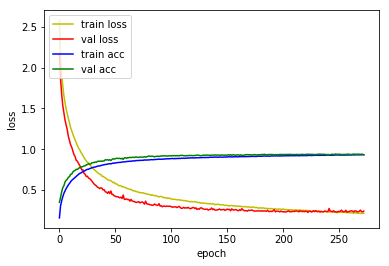

4815/4815 [==============================] - 2s 396us/sample - loss: 0.2775 - acc: 0.9192
Loss: 0.2775282277496433 Accuracy: 0.9192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4646 - acc: 0.1887
Epoch 00001: val_loss improved from inf to 1.92446, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_6_conv_checkpoint/001-1.9245.hdf5
36805/36805 [==============================] - 34s 935us/sample - loss: 2.4645 - acc: 0.1888 - val_loss: 1.9245 - val_acc: 0.4051
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8992 - acc: 0.3699
Epoch 00002: val_loss improved from 1.92446 to 1.60049, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_6_conv_checkpoint/002-1.6005.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 1.8992 - acc: 0.3699 - val_loss: 1.6005 - val_acc: 0.5085
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5149 - acc: 0.8482
Epoch 00023: val_loss did not improve from 0.34812
36805/36805 [==============================] - 31s 846us/sample - loss: 0.5148 - acc: 0.8483 - val_loss: 0.3807 - val_acc: 0.8973
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4943 - acc: 0.8535
Epoch 00024: val_loss did not improve from 0.34812
36805/36805 [==============================] - 31s 847us/sample - loss: 0.4942 - acc: 0.8536 - val_loss: 0.3563 - val_acc: 0.9005
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4812 - acc: 0.8571
Epoch 00025: val_loss improved from 0.34812 to 0.33890, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_6_conv_checkpoint/025-0.3389.hdf5
36805/36805 [==============================] - 31s 848us/sample - loss: 0.4812 - acc: 0.8571 - val_loss: 0.3389 - val_acc: 0.9061
Epoch 26/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3074 - acc: 0.9072
Epoch 00047: val_loss did not improve from 0.20865
36805/36805 [==============================] - 31s 845us/sample - loss: 0.3074 - acc: 0.9072 - val_loss: 0.2383 - val_acc: 0.9306
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2988 - acc: 0.9094
Epoch 00048: val_loss improved from 0.20865 to 0.20171, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_6_conv_checkpoint/048-0.2017.hdf5
36805/36805 [==============================] - 31s 849us/sample - loss: 0.2988 - acc: 0.9094 - val_loss: 0.2017 - val_acc: 0.9425
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2936 - acc: 0.9109
Epoch 00049: val_loss improved from 0.20171 to 0.19634, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_6_conv_checkpoint/049-0.1963.hdf5
36805/36805 [==============================] - 31s 848us/sample - loss: 0.2936 - acc: 0.9109 - val_loss: 0.

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2187 - acc: 0.9324
Epoch 00073: val_loss did not improve from 0.16746
36805/36805 [==============================] - 31s 847us/sample - loss: 0.2187 - acc: 0.9324 - val_loss: 0.1702 - val_acc: 0.9529
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2194 - acc: 0.9329
Epoch 00074: val_loss did not improve from 0.16746
36805/36805 [==============================] - 31s 847us/sample - loss: 0.2195 - acc: 0.9328 - val_loss: 0.1752 - val_acc: 0.9464
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2172 - acc: 0.9312
Epoch 00075: val_loss did not improve from 0.16746
36805/36805 [==============================] - 31s 850us/sample - loss: 0.2172 - acc: 0.9312 - val_loss: 0.1676 - val_acc: 0.9553
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9326
Epoch 00076: val_loss did not improve from 0.16746
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.1728 - acc: 0.9447
Epoch 00100: val_loss did not improve from 0.14239
36805/36805 [==============================] - 31s 844us/sample - loss: 0.1728 - acc: 0.9447 - val_loss: 0.1522 - val_acc: 0.9571
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9465
Epoch 00101: val_loss did not improve from 0.14239
36805/36805 [==============================] - 31s 845us/sample - loss: 0.1653 - acc: 0.9465 - val_loss: 0.1544 - val_acc: 0.9543
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.9435
Epoch 00102: val_loss improved from 0.14239 to 0.14040, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_6_conv_checkpoint/102-0.1404.hdf5
36805/36805 [==============================] - 31s 846us/sample - loss: 0.1781 - acc: 0.9435 - val_loss: 0.1404 - val_acc: 0.9613
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.1322 - acc: 0.9566
Epoch 00129: val_loss did not improve from 0.14040
36805/36805 [==============================] - 31s 845us/sample - loss: 0.1322 - acc: 0.9566 - val_loss: 0.1446 - val_acc: 0.9602
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9566
Epoch 00130: val_loss did not improve from 0.14040
36805/36805 [==============================] - 31s 844us/sample - loss: 0.1328 - acc: 0.9566 - val_loss: 0.1608 - val_acc: 0.9550
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1294 - acc: 0.9576
Epoch 00131: val_loss did not improve from 0.14040
36805/36805 [==============================] - 31s 844us/sample - loss: 0.1294 - acc: 0.9576 - val_loss: 0.1565 - val_acc: 0.9602
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1301 - acc: 0.9575
Epoch 00132: val_loss did not improve from 0.14040
36805/36805 [===============

Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9643
Epoch 00158: val_loss did not improve from 0.13625
36805/36805 [==============================] - 31s 832us/sample - loss: 0.1061 - acc: 0.9644 - val_loss: 0.1562 - val_acc: 0.9599
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9652
Epoch 00159: val_loss did not improve from 0.13625
36805/36805 [==============================] - 31s 845us/sample - loss: 0.1052 - acc: 0.9652 - val_loss: 0.1495 - val_acc: 0.9632
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9656
Epoch 00160: val_loss did not improve from 0.13625
36805/36805 [==============================] - 31s 843us/sample - loss: 0.1075 - acc: 0.9656 - val_loss: 0.1534 - val_acc: 0.9632
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9651
Epoch 00161: val_loss did not improve from 0.13625
36805/36805 [=

Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9701
Epoch 00188: val_loss did not improve from 0.13625
36805/36805 [==============================] - 31s 842us/sample - loss: 0.0885 - acc: 0.9701 - val_loss: 0.1545 - val_acc: 0.9648
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9704
Epoch 00189: val_loss did not improve from 0.13625
36805/36805 [==============================] - 31s 842us/sample - loss: 0.0887 - acc: 0.9704 - val_loss: 0.1534 - val_acc: 0.9620
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0871 - acc: 0.9709
Epoch 00190: val_loss did not improve from 0.13625
36805/36805 [==============================] - 31s 842us/sample - loss: 0.0871 - acc: 0.9709 - val_loss: 0.1587 - val_acc: 0.9627
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9720
Epoch 00191: val_loss did not improve from 0.13625
36805/36805 [=

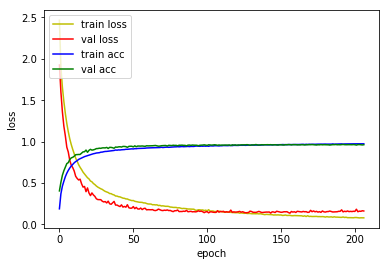

4815/4815 [==============================] - 2s 421us/sample - loss: 0.1785 - acc: 0.9508
Loss: 0.17850961259190043 Accuracy: 0.95077884

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3062 - acc: 0.2465
Epoch 00001: val_loss improved from inf to 1.54815, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_7_conv_checkpoint/001-1.5482.hdf5
36805/36805 [==============================] - 35s 960us/sample - loss: 2.3062 - acc: 0.2465 - val_loss: 1.5482 - val_acc: 0.5653
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4910 - acc: 0.5240
Epoch 00002: val_loss improved from 1.54815 to 1.06334, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_7_conv_checkpoint/002-1.0633.hdf5
36805/36805 [==============================] - 32s 865us/sample - loss: 1.4910 - acc: 0.5240 - val_loss: 1.0633 - val_acc: 0.6981
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2834 - acc: 0.9124
Epoch 00023: val_loss improved from 0.19316 to 0.18623, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_7_conv_checkpoint/023-0.1862.hdf5
36805/36805 [==============================] - 32s 870us/sample - loss: 0.2834 - acc: 0.9124 - val_loss: 0.1862 - val_acc: 0.9425
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2722 - acc: 0.9149
Epoch 00024: val_loss improved from 0.18623 to 0.18054, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_7_conv_checkpoint/024-0.1805.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 0.2723 - acc: 0.9149 - val_loss: 0.1805 - val_acc: 0.9432
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2644 - acc: 0.9170
Epoch 00025: val_loss improved from 0.18054 to 0.17366, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_7_conv_checkpoint/025-0.173

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1500 - acc: 0.9504
Epoch 00049: val_loss did not improve from 0.13220
36805/36805 [==============================] - 32s 865us/sample - loss: 0.1500 - acc: 0.9504 - val_loss: 0.1624 - val_acc: 0.9520
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1493 - acc: 0.9519
Epoch 00050: val_loss did not improve from 0.13220
36805/36805 [==============================] - 32s 868us/sample - loss: 0.1492 - acc: 0.9519 - val_loss: 0.1399 - val_acc: 0.9597
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1457 - acc: 0.9517
Epoch 00051: val_loss did not improve from 0.13220
36805/36805 [==============================] - 32s 863us/sample - loss: 0.1457 - acc: 0.9517 - val_loss: 0.1361 - val_acc: 0.9592
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1402 - acc: 0.9545
Epoch 00052: val_loss did not improve from 0.13220
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9682
Epoch 00077: val_loss did not improve from 0.12339
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0933 - acc: 0.9682 - val_loss: 0.1299 - val_acc: 0.9644
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9701
Epoch 00078: val_loss did not improve from 0.12339
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0915 - acc: 0.9701 - val_loss: 0.1301 - val_acc: 0.9655
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9714
Epoch 00079: val_loss did not improve from 0.12339
36805/36805 [==============================] - 32s 869us/sample - loss: 0.0878 - acc: 0.9714 - val_loss: 0.1316 - val_acc: 0.9625
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9701
Epoch 00080: val_loss did not improve from 0.12339
36805/36805 [==================

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9794
Epoch 00106: val_loss did not improve from 0.11804
36805/36805 [==============================] - 32s 870us/sample - loss: 0.0626 - acc: 0.9794 - val_loss: 0.1501 - val_acc: 0.9641
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9799
Epoch 00107: val_loss did not improve from 0.11804
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0608 - acc: 0.9799 - val_loss: 0.1331 - val_acc: 0.9634
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9813
Epoch 00108: val_loss did not improve from 0.11804
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0558 - acc: 0.9813 - val_loss: 0.1324 - val_acc: 0.9660
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9798
Epoch 00109: val_loss did not improve from 0.11804
36805/36805 [=

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9856
Epoch 00136: val_loss did not improve from 0.11804
36805/36805 [==============================] - 32s 869us/sample - loss: 0.0428 - acc: 0.9856 - val_loss: 0.1686 - val_acc: 0.9641
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9854
Epoch 00137: val_loss did not improve from 0.11804
36805/36805 [==============================] - 32s 869us/sample - loss: 0.0432 - acc: 0.9854 - val_loss: 0.1627 - val_acc: 0.9658
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9867
Epoch 00138: val_loss did not improve from 0.11804
36805/36805 [==============================] - 32s 867us/sample - loss: 0.0392 - acc: 0.9867 - val_loss: 0.1718 - val_acc: 0.9625
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9853
Epoch 00139: val_loss did not improve from 0.11804
36805/36805 [=

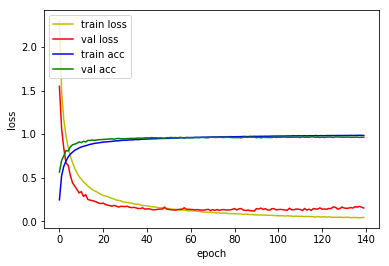

4815/4815 [==============================] - 2s 444us/sample - loss: 0.1744 - acc: 0.9510
Loss: 0.17435325513422675 Accuracy: 0.9509865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0573 - acc: 0.3314
Epoch 00001: val_loss improved from inf to 1.15250, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_8_conv_checkpoint/001-1.1525.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 2.0572 - acc: 0.3314 - val_loss: 1.1525 - val_acc: 0.6560
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1355 - acc: 0.6381
Epoch 00002: val_loss improved from 1.15250 to 0.72865, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_8_conv_checkpoint/002-0.7286.hdf5
36805/36805 [==============================] - 33s 888us/sample - loss: 1.1355 - acc: 0.6381 - val_loss: 0.7286 - val_acc: 0.7813
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1767 - acc: 0.9436
Epoch 00023: val_loss did not improve from 0.14522
36805/36805 [==============================] - 33s 885us/sample - loss: 0.1767 - acc: 0.9436 - val_loss: 0.1454 - val_acc: 0.9555
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9432
Epoch 00024: val_loss improved from 0.14522 to 0.13577, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_DO_8_conv_checkpoint/024-0.1358.hdf5
36805/36805 [==============================] - 33s 887us/sample - loss: 0.1732 - acc: 0.9432 - val_loss: 0.1358 - val_acc: 0.9599
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1680 - acc: 0.9450
Epoch 00025: val_loss did not improve from 0.13577
36805/36805 [==============================] - 33s 886us/sample - loss: 0.1680 - acc: 0.9450 - val_loss: 0.1492 - val_acc: 0.9539
Epoch 26/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9761
Epoch 00050: val_loss did not improve from 0.12574
36805/36805 [==============================] - 33s 883us/sample - loss: 0.0705 - acc: 0.9761 - val_loss: 0.1390 - val_acc: 0.9627
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9767
Epoch 00051: val_loss did not improve from 0.12574
36805/36805 [==============================] - 32s 880us/sample - loss: 0.0681 - acc: 0.9767 - val_loss: 0.1487 - val_acc: 0.9597
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9756
Epoch 00052: val_loss did not improve from 0.12574
36805/36805 [==============================] - 33s 887us/sample - loss: 0.0710 - acc: 0.9756 - val_loss: 0.1273 - val_acc: 0.9644
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9786
Epoch 00053: val_loss did not improve from 0.12574
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9871
Epoch 00080: val_loss did not improve from 0.12574
36805/36805 [==============================] - 33s 884us/sample - loss: 0.0376 - acc: 0.9871 - val_loss: 0.1776 - val_acc: 0.9641
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9865
Epoch 00081: val_loss did not improve from 0.12574
36805/36805 [==============================] - 33s 883us/sample - loss: 0.0395 - acc: 0.9865 - val_loss: 0.1742 - val_acc: 0.9590
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9879
Epoch 00082: val_loss did not improve from 0.12574
36805/36805 [==============================] - 33s 885us/sample - loss: 0.0367 - acc: 0.9879 - val_loss: 0.1590 - val_acc: 0.9625
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0369 - acc: 0.9874
Epoch 00083: val_loss did not improve from 0.12574
36805/36805 [=====

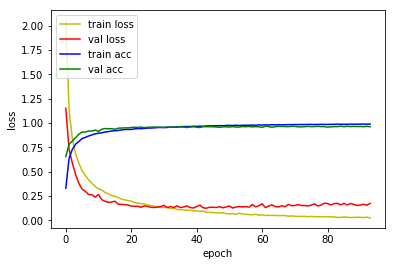

4815/4815 [==============================] - 2s 479us/sample - loss: 0.2174 - acc: 0.9394
Loss: 0.21736131861442284 Accuracy: 0.9393562



In [10]:
base = '1D_CNN_custom_multi_2_GAP_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 2s 476us/sample - loss: 0.2775 - acc: 0.9192
Loss: 0.2775282277496433 Accuracy: 0.9192108

1D_CNN_custom_multi_2_GAP_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 64)    384         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 64)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPooling1D

4815/4815 [==============================] - 2s 511us/sample - loss: 0.1744 - acc: 0.9510
Loss: 0.17435325513422675 Accuracy: 0.9509865

1D_CNN_custom_multi_2_GAP_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 64)    384         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 64)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPooling1

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 3s 525us/sample - loss: 0.2985 - acc: 0.9126
Loss: 0.29848054330544554 Accuracy: 0.9125649

1D_CNN_custom_multi_2_GAP_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 64)    384         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 64)    0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPooling1

4815/4815 [==============================] - 3s 549us/sample - loss: 0.2010 - acc: 0.9549
Loss: 0.20104904692554276 Accuracy: 0.9549325

1D_CNN_custom_multi_2_GAP_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 64)    384         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 64)    0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxPooling1